In [335]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def parratt_reflectivity(wavelength,n_substrate,n_film,t_film,alpha_i):
    k0 = 2*np.pi/wavelength
    num_slice = 150.
    slice_thick = t_film/num_slice
    layers = np.arange(0,-t_film-slice_thick,-slice_thick)
    n_layers = np.zeros((len(layers),1),dtype=np.complex128)
    X = np.zeros((len(layers),1),dtype=np.complex128)
    
    # layer assignments
    n_layers[0] = 1 + 0.j
    n_layers[1:-1] = n_film
    n_layers[-1] = n_substrate
    
    Rf = np.zeros((len(alphai),1),dtype=np.complex128)
    idx = 0
    for k in alphai:
        # z-component of wavevector
        kz = k0*np.sqrt(n_layers**2-np.cos(k)**2)
        r = (kz[0:-1] - kz[1:len(n_layers)+1])/(kz[0:-1] + kz[1:len(n_layers)+1])

        for i in range(len(n_layers)-2,-1,-1):
            X[i] = (np.exp(-2.j*kz[i]*layers[i]) * 
                    (r[i]+X[i+1]*np.exp(2.j*kz[i+1]*layers[i])) / 
                    (1+r[i]*X[i+1]*np.exp(2.j*kz[i+1]*layers[i])))
        Rf[idx] = X[0]
        idx += 1
    return Rf

def EFI_calc(wavelength, n_substrate, n_film, t_film, alpha_i):
    k0 = 2*np.pi/wavelength
    num_slice = 200.
    slice_thick = t_film/num_slice
    layers = np.arange(0,-t_film-slice_thick,-slice_thick)
    layers = layers.reshape(len(layers),1)
    n_layers = np.zeros((len(layers),1),dtype=np.complex128)
    R = np.zeros((len(layers),1),dtype=np.complex128)
    T = np.zeros((len(layers),1),dtype=np.complex128)
    X = np.zeros((len(layers),1),dtype=np.complex128)
    EFI = np.zeros((len(layers),len(alphai)))
    
    # layer assignments
    n_layers[0] = 1 + 0.j
    n_layers[1:-1] = n_film
    n_layers[-1] = n_substrate
    
    Rf = np.zeros((len(alphai),1),dtype=np.complex128)
    idx = 0
    for k in alphai:
        # z-component of wavevector
        kz = k0*np.sqrt(n_layers**2-np.cos(k)**2)
        r = (kz[0:-1] - kz[1:len(n_layers)+1])/(kz[0:-1] + kz[1:len(n_layers)+1]) # for reflectivity calculation
        
        # Recursion to calculate reflectivity at surface
        for i in range(len(n_layers)-2,-1,-1):
            X[i] = (np.exp(-2.j*kz[i]*layers[i]) * 
                    (r[i]+X[i+1]*np.exp(2.j*kz[i+1]*layers[i])) / 
                    (1+r[i]*X[i+1]*np.exp(2.j*kz[i+1]*layers[i])))
        Rf[idx] = X[0]
        R[0] = X[0]
        T[0] = 1
        # Recursion to calculate R, T in film and used to calculate EFI
        rj1j = (kz[1:len(n_layers)+1] - kz[0:-1])/(kz[0:-1] + kz[1:len(n_layers)+1]) # for calculating R, T in film
        tj1j = 1 + rj1j
        for i in range(0,len(n_layers)-1):
            R[i+1] = ((1/tj1j[i]) * 
                      (T[i]*rj1j[i]*np.exp(-1.j*(kz[i+1] + kz[i])*layers[i]) + 
                      R[i]*np.exp(-1.j*(kz[i+1] - kz[i])*layers[i])))
            T[i+1] = ((1/tj1j[i]) * 
                      (T[i]*np.exp(1.j*(kz[i+1] - kz[i])*layers[i]) + 
                      R[i]*rj1j[i]*np.exp(1.j*(kz[i+1] + kz[i])*layers[i])))
        R[-1] = 0
        ER = R*np.exp(1.j*kz*layers)
        ET = T*np.exp(-1.j*kz*layers)
        EFI[:,idx] = (np.abs(ER + ET)**2).ravel()
        idx += 1
    return EFI

In [70]:
# Wavelength and Material parameters
xlambda = 1.54 # wavelength in angstroms

# Silicon
delta_Si = 7.56*10**(-6)
beta_Si = delta_Si/40.
n_Si = complex(1 - delta_Si, beta_Si)

# Polystyrene
delta_PS = 3.5*10**(-6)
beta_PS = delta_PS/200.
tfilm = 2000 # thickness in angstroms
n_PS = complex(1-delta_PS, beta_PS)


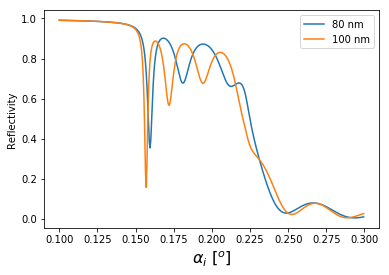

In [304]:
alphai = np.arange(0.1,0.3,.0005)/180*np.pi
# alphai = [0.18*180/np.pi]
ref1 = parratt_reflectivity(1.54,n_Si,n_PS,800,alphai)
ref2 = parratt_reflectivity(1.54,n_Si,n_PS,1000,alphai)
plt.plot(alphai*180/np.pi,np.abs(ref1)**2)
plt.plot(alphai*180/np.pi,np.abs(ref2)**2)
plt.xlabel(r'$\alpha_i$ $[^o]$',FontSize=16)
plt.ylabel('Reflectivity')
plt.legend(('80 nm','100 nm'))
plt.show()

In [337]:
%matplotlib qt
import scipy as sp
alphai = np.arange(0.1,.2,.00025)/180*np.pi
# alphai = [0.1*np.pi/180]
EFI = EFI_calc(1.54,n_Si,n_PS,800,alphai)
sns.heatmap(EFI,cmap="jet")

In [334]:
plt.imshow(EFI,cmap="jet")
plt.show()